In [5]:
import time
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
from scipy.spatial import cKDTree as KDTree
import os
import random
import numpy as np
import pandas as pd 
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import OPTICS
from glob import glob 
from tqdm import tqdm
from scipy.spatial.distance import pdist , squareform
np.random.seed(5)
import itertools


# #Fix Directory
# abspath = os.path.abspath(__file__)
# dname = os.path.dirname(abspath)
# os.chdir(dname)

# path = os.getcwd()
# PATH_storage = path
# print(PATH_storage)

# patient_frame_to_store = 'Patient_generated_binary_only_mutliple_gaussian'
# if not os.path.exists(patient_frame_to_store):
#     os.makedirs(patient_frame_to_store)
# path_to_store_patient_frame = os.path.join(PATH_storage, patient_frame_to_store)

# abspath = os.path.abspath(__file__)
# dname = os.path.dirname(abspath)
# os.chdir(dname)

# path = os.getcwd()
# PATH_storage = path
# print(PATH_storage)


# #Chose to work on continuous data
# figures_storage ,frame_storage = 'Figures_LDA_on_binary_data_generated_mutliple_gaussian' , 'Data_frame_LDA_on_binary_data_generated_mutliple_gaussian'

# if not os.path.exists(figures_storage):
#     os.makedirs(figures_storage)
# path_to_store_figures = os.path.join(PATH_storage, figures_storage)

# if not os.path.exists(frame_storage):
#     os.makedirs(frame_storage)
# path_to_store_frame = os.path.join(PATH_storage, frame_storage)



#Def for generate patients
def generate_data(number_of_cell_to_generate, proba_tupple):
    size_list = number_of_cell_to_generate
    probas = proba_tupple
    number_of_iteration = tuple([int(size_list*x) for x in probas])

    list_of_iteration = []
    for i in range(len(number_of_iteration)):
        a = [i]*number_of_iteration[i]
        list_of_iteration += a

    return list_of_iteration


number_of_cell_to_generate = 10000 #Number of cell

#Define parameters for LDA
diviser_of_matrix = 100
number_of_calculation = 50
number_of_topic_to_test = 10
        #Parameters for cutting dendrogram
cutting_tree = 1

n_sample = 5000 #Number of cell subset randomly chosen
strating_point = 0
number_of_cluster = 3 #Number_of_cluster_for_k_means
max_val = 0.01

#Generate patients
number_of_patients = 50
number_of_cell_phenotypes = 7
number_of_feature_to_generate = 1
patient_phenotypes = 2

configuration = 0
#for configuration in tqdm(np.arange(0,0.85,0.05)):
proba_tupple = (0.85-configuration,0.05,0.05,0.05+configuration) 
proba_tupple_2 = (0.05+configuration, 0.05,0.05,0.85-configuration) 
phenotype_code = []
stacked_frame = []

for patient in tqdm(range(number_of_patients)):
    random_state = 41
    phenotype_continuous_data = []
    phenotype_binary_data = []
    if patient < number_of_patients/patient_phenotypes:
        phenotype_code.append(1)
        data_generated = generate_data(number_of_cell_to_generate,proba_tupple)
        equivalent = np.array(list(itertools.product([0, 1], repeat=2)))
        binary_result = np.stack([equivalent[u] for u in data_generated])
    else:
        phenotype_code.append(2)
        data_generated_2 = generate_data(number_of_cell_to_generate,proba_tupple_2)
        equivalent = np.array(list(itertools.product([0, 1], repeat=2)))
        binary_result = np.stack([equivalent[u] for u in data_generated_2])
    
    stacked_frame.append(binary_result)





100%|██████████| 50/50 [00:00<00:00, 97.27it/s]


In [6]:
tech = []
for array in stacked_frame:
    tech.append(pd.DataFrame(pd.DataFrame(array).value_counts(sort=False))[0].tolist())

tech = pd.DataFrame(tech)

In [7]:
tech.T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,8500,8500,8500,8500,8500,8500,8500,8500,8500,8500,...,500,500,500,500,500,500,500,500,500,500
1,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500
2,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500
3,500,500,500,500,500,500,500,500,500,500,...,8500,8500,8500,8500,8500,8500,8500,8500,8500,8500


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]
1.0
(50, 50)


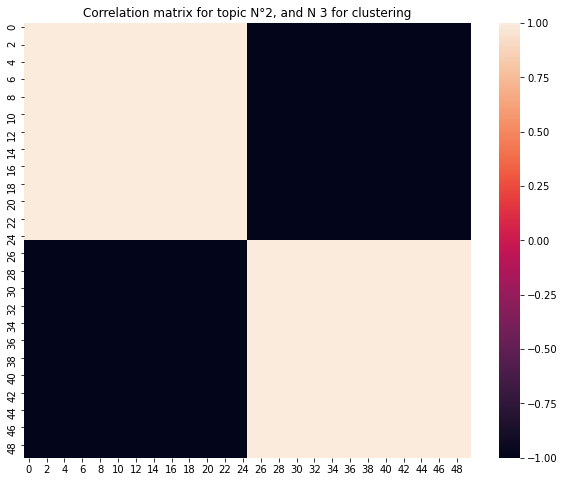

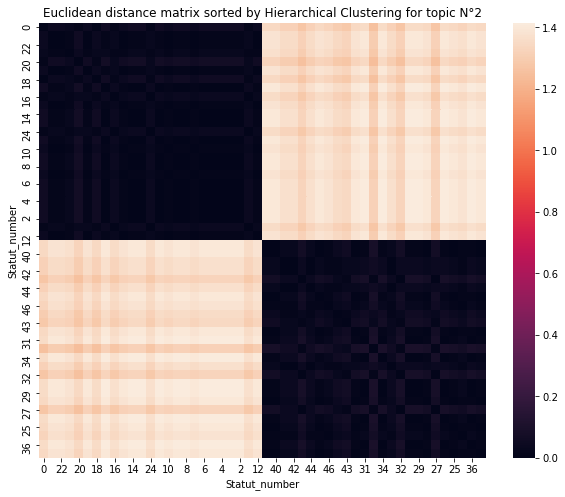

In [9]:
#for runrun in range(2, number_of_topic_to_test + 1):
for runrun in range(2, 3):
    excluded_patient = 0
    vocabulary  =  list(range(tech.shape[1]))
    raw_data_T4 = tech.T
    data_T4 = raw_data_T4.T
    t4_ = data_T4.to_numpy()/diviser_of_matrix

    #t4_ = np.around(t4_)
    docs = []
    npatients, nvocabulary = t4_.shape
    for n in range (npatients):
        current_doc = []
        doc = t4_[n,:]
        for i in range(nvocabulary):
            for _ in range(int(doc[i])):
                current_doc.append(i)
        docs.append(current_doc)
                
            

    D = len(docs)        # number of documents
    V = len(vocabulary)  # size of the vocabulary 
    T = runrun            # number of topics

    alpha = 1 / T         # the parameter of the Dirichlet prior on the per-document topic distributions
    beta = 1 / T        # the parameter of the Dirichlet prior on the per-topic word distribution


    z_d_n = [[0 for _ in range(len(d))] for d in docs]  # z_i_j
    theta_d_z = np.zeros((D, T))
    phi_z_w = np.zeros((T, V))
    n_d = np.zeros((D))
    n_z = np.zeros((T))

    ## Initialize the parameters
    # m: doc id
    for d, doc in enumerate(docs):  
        # n: id of word inside document, w: id of the word globally
        for n, w in enumerate(doc):
            # assign a topic randomly to words
            z_d_n[d][n] = int(np.random.randint(T))
            # get the topic for word n in document m
            z = z_d_n[d][n]
            # keep track of our counts
            theta_d_z[d][z] += 1
            phi_z_w[z, w] += 1
            n_z[z] += 1
            n_d[d] += 1

    for iteration in tqdm(range(number_of_calculation)):
        for d, doc in enumerate(docs):
            for n, w in enumerate(doc):
                # get the topic for word n in document m
                z = z_d_n[d][n]

                # decrement counts for word w with associated topic z
                theta_d_z[d][z] -= 1
                phi_z_w[z, w] -= 1
                n_z[z] -= 1

                # sample new topic from a multinomial according to our formular
                p_d_t = (theta_d_z[d] + alpha) / (n_d[d] - 1 + T * alpha)
                p_t_w = (phi_z_w[:, w] + beta) / (n_z + V * beta)
                p_z = p_d_t * p_t_w
                p_z /= np.sum(p_z)
                #new_z = np.random.multinomial(1, p_z).argmax()
                new_z = np.random.choice(len(p_z), 1, p=p_z)[0] 

                # set z as the new topic and increment counts
                z_d_n[d][n] = new_z
                theta_d_z[d][new_z] += 1
                phi_z_w[new_z, w] += 1
                n_z[new_z] += 1


    norm_theta = theta_d_z.copy()
    ns = np.sum(theta_d_z, axis=1)
    for i in range(ns.shape[0]):
        norm_theta[i, :] /= ns[i]
    print(np.max(norm_theta))
    corr_matrix = np.dot(norm_theta, norm_theta.T)
    print(corr_matrix.shape)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pd.DataFrame(corr_matrix, index=raw_data_T4.columns, columns=raw_data_T4.columns).corr())
    plt.title(f'Correlation matrix for topic N°%s, and N {number_of_cluster} for clustering' %runrun)
    #plt.savefig(path_to_store_figures + f'/corr_matrix_on_binary_data_generated_topic_%s_N_{number_of_cluster}_for_kmeans.png'%runrun)
    #(pd.DataFrame(norm_theta)).to_csv(path_to_store_frame + f'/LDA_DATAFRAME_Topic_{runrun}.csv')
    #plt.close()


    linked = linkage(norm_theta, 'complete')
    labelList = raw_data_T4.columns.to_list()

    plt.figure(figsize=(10, 7))
    dendrogram(linked,
                orientation='top',
                labels=labelList,
                distance_sort='descending',
                show_leaf_counts=True)
    #plt.savefig(path_to_store_figures + f'/Cluster_dendrogram_for_topic_%s.png'%runrun)
    plt.close()

    hierarchical_result = fcluster(linked, cutting_tree*norm_theta.max(),'distance')
    frame_binary_with_threshold = pd.DataFrame(norm_theta,index=data_T4.index,columns= [f'Topic {i}' for i in range(runrun)])

    frame_binary_with_threshold['Statut_number'] =  frame_binary_with_threshold.index
    frame_binary_with_threshold.reset_index(drop=True, inplace=True)
    frame_binary_with_threshold['Hierarchical_clustering'] = hierarchical_result
    frame_binary_with_threshold['Phenotype'] = phenotype_code
    #frame_binary_with_threshold.groupby(['Phenotype','Hierarchical_clustering']).size().unstack(fill_value=0).to_csv(path_to_store_frame + f'/Confusion_matrix_Topic_{runrun}_with_n_{number_of_cluster}.csv')

    sorted_frame_cell_info_threshold_and_analysis = frame_binary_with_threshold.sort_values(by=['Hierarchical_clustering'])

    result_to_analyse = pdist(sorted_frame_cell_info_threshold_and_analysis[[col for col in frame_binary_with_threshold if col.startswith('Topic')]], 'euclidean')
    squareform(result_to_analyse)
    distance_topics = pd.DataFrame(squareform(result_to_analyse), index = sorted_frame_cell_info_threshold_and_analysis['Statut_number'], columns=sorted_frame_cell_info_threshold_and_analysis['Statut_number'] )
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_topics)
    plt.title(f'Euclidean distance matrix sorted by Hierarchical Clustering for topic N°%s' %runrun)
    #plt.savefig(path_to_store_figures + f'/Euclidian_distance_matrix_sorted_by_Hierarchical_Clustering_for_topic_%s_and_N_{number_of_cluster}.png'%runrun)
    #plt.close()

In [16]:
test = frame_binary_with_threshold.groupby(['Phenotype','Hierarchical_clustering']).size().unstack(fill_value=0)

In [69]:
accuracy_list = []
error_list = []

for phenotype in range(patient_phenotypes):
    accuracy = np.sum(test.iloc[phenotype].values)/(number_of_patients/patient_phenotypes)
    error = 1-accuracy

    accuracy_list.append(accuracy)
    error_list.append(error)

accuracy_value = np.mean(accuracy_list)
error_value = np.mean()

In [72]:
np.mean(accuracy_list)

1.0